In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# can check if you are using your GPU. 
# macOS users -> this will not work, you need to go through a great deal of pain to get it working

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU yes")
else:
    print("No GPU")

GPU yes


In [3]:
import matplotlib.pyplot as plt

In [4]:
nl_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/train_set/big_data.csv')
# test_set = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/test_set/processed_data.csv')

/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_15030/726461521.py:1: DtypeWarning: Columns (18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  nl_df = pd.read_csv('/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/NL_data/train_set/big_data.csv')


In [5]:
# due (i suppose) to the large size of the file, there was an issue with some dummy variables, we can fix it easily

nl_df['time'] = pd.to_datetime(nl_df['time'])
affected_month_columns = ['month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
df_dummies = pd.get_dummies(nl_df['time'].dt.month, prefix = 'month', dummy_na = True)
nl_df[affected_month_columns] = df_dummies[['month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0']]
nl_df = nl_df.sort_values(by = ['time'])

# can get all "major" cities df below
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]
middelburg_df = nl_df[(nl_df['latitude'] == 51.50) & (nl_df['longitude'] == 3.5)]
hertogenbosch_df = nl_df[(nl_df['latitude'] == 51.75) & (nl_df['longitude'] == 5.5)]
maastricht_df = nl_df[(nl_df['latitude'] == 51.) & (nl_df['longitude'] == 5.75)]
utrecht_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 5.)]
hague_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 4.25)]
arnhem_df = nl_df[(nl_df['latitude'] == 52.) & (nl_df['longitude'] == 6.)]
lelystad_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 5.5)]
zwolle_df = nl_df[(nl_df['latitude'] == 52.5) & (nl_df['longitude'] == 6.)]
leeuwarden_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 5.75)]
assen_df = nl_df[(nl_df['latitude'] == 53.) & (nl_df['longitude'] == 6.5)]
groningen_df = nl_df[(nl_df['latitude'] == 53.25) & (nl_df['longitude'] == 6.5)]

ams_tr, ams_ts = ams_df.iloc[:122712], ams_df.iloc[122712:]
middelburg_tr, middelburg_ts = middelburg_df.iloc[:122712], middelburg_df.iloc[122712:]
hertogenbosch_tr, hertogenbosch_ts = hertogenbosch_df.iloc[:122712], hertogenbosch_df.iloc[122712:]
maastricht_tr, maastricht_ts = maastricht_df.iloc[:122712], maastricht_df.iloc[122712:]
utrecht_tr, utrecht_ts = utrecht_df.iloc[:122712], utrecht_df.iloc[122712:]
hague_tr, hague_ts = hague_df.iloc[:122712], hague_df.iloc[122712:]
arnhem_tr, arnhem_ts = arnhem_df.iloc[:122712], arnhem_df.iloc[122712:]
lelystad_tr, lelystad_ts = lelystad_df[:122712], lelystad_df[122712:]
zwolle_tr, zwolle_ts = zwolle_df[:122712], zwolle_df[122712:]
leeuwarden_tr, leeuwarden_ts = leeuwarden_df[:122712], leeuwarden_df[122712:]
assen_tr, assen_ts = assen_df[:122712], assen_df[122712:]
groningen_tr, groningen_ts = groningen_df.iloc[:122712], groningen_df.iloc[122712:]

In [6]:
dataframes_tr = [ams_tr, middelburg_tr, hertogenbosch_tr, maastricht_tr, utrecht_tr, hague_tr, arnhem_tr, 
              lelystad_tr, zwolle_tr, leeuwarden_tr, assen_tr, groningen_tr]

df_names = ['ams', 'middelburg', 'hertogenbosch', 'maastricht', 'utrecht', 'hague', 'arnhem', 
            'lelystad', 'zwolle', 'leeuwarden', 'assen', 'groningen']

In [33]:
len(ams_tr)

122712

In [7]:
X_train_df = {}
X_valid_df = {}
Y_train_df = {}
Y_valid_df = {}

for i, city in enumerate(dataframes_tr):
    df = city.set_index('time').copy()
    city_train = pd.DataFrame()
    city_valid = pd.DataFrame()

    train_size = round(len(df) * 0.8)

    city_train = df.iloc[:train_size]
    city_valid = df.iloc[train_size:]

    X_train = city_train[['u10', 'v10','tcc', 'ptype', 'e', 'sf', 'tp']]
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_train = city_train['t2m']
    X_valid = city_valid[['u10', 'v10','tcc', 'ptype', 'e', 'sf', 'tp']]
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_valid =  city_valid['t2m']

    Y_valid = Y_valid.values
    Y_train = Y_train.values
    Y_train, Y_valid = Y_train.reshape(-1, 1), Y_valid.reshape(-1, 1)

    scaler = MinMaxScaler()
    X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_valid)
    Y_train_scaled, Y_valid_scaled = scaler.fit_transform(Y_train), scaler.fit_transform(Y_valid)

    # so, you need a timestep that divides the length of the dataset into an integer.
    # a lower timestep seems to work better than larger ones

    # so we need to find a dimension for which we can fit 2 timesteps (or any multiple of 2 ?) * 41 columns

    # this extremely impactful, need to tune it somehow
    timestep = 24 # pick a timestep, can be anything, used for length of sequence in LSTM

    # below is a general formula to reshape the tensors without errors
    train_trim = X_train_scaled.shape[0] - (X_train_scaled.shape[0] // (timestep * X_train_scaled.shape[1])) * (timestep * X_train_scaled.shape[1])
    valid_trim = X_valid_scaled.shape[0] - (X_valid_scaled.shape[0] // (timestep * X_valid_scaled.shape[1])) * (timestep * X_valid_scaled.shape[1])

    # now can just apply the trim, will work with any value
    X_train_scaled, X_valid_scaled = X_train_scaled[:-train_trim], X_valid_scaled[:-valid_trim]
    Y_train_scaled, Y_valid_scaled = Y_train_scaled[:-train_trim], Y_valid_scaled[:-valid_trim]

    # reshape and convert to tensors
    X_train_tensor = tf.convert_to_tensor(X_train_scaled.reshape(-1, timestep, X_train_scaled.shape[1]))
    X_valid_tensor = tf.convert_to_tensor(X_valid_scaled.reshape(-1, timestep, X_valid_scaled.shape[1]))

    # convert the data to tensors
    Y_train_tensor = tf.convert_to_tensor(Y_train_scaled.reshape(-1, timestep), dtype=tf.float32)
    Y_valid_tensor = tf.convert_to_tensor(Y_valid_scaled.reshape(-1, timestep), dtype=tf.float32)

    X_train_df[df_names[i]] = X_train_tensor
    X_valid_df[df_names[i]] = X_valid_tensor
    Y_train_df[df_names[i]] = Y_train_tensor
    Y_valid_df[df_names[i]] = Y_valid_tensor

2024-05-23 15:03:12.395259: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-23 15:03:12.395307: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-23 15:03:12.395317: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-23 15:03:12.395645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-23 15:03:12.395945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
dataframes_ts = [ams_ts, middelburg_ts, hertogenbosch_ts, maastricht_ts, utrecht_ts, hague_ts, arnhem_ts, 
              lelystad_ts, zwolle_ts, leeuwarden_ts, assen_ts, groningen_ts]

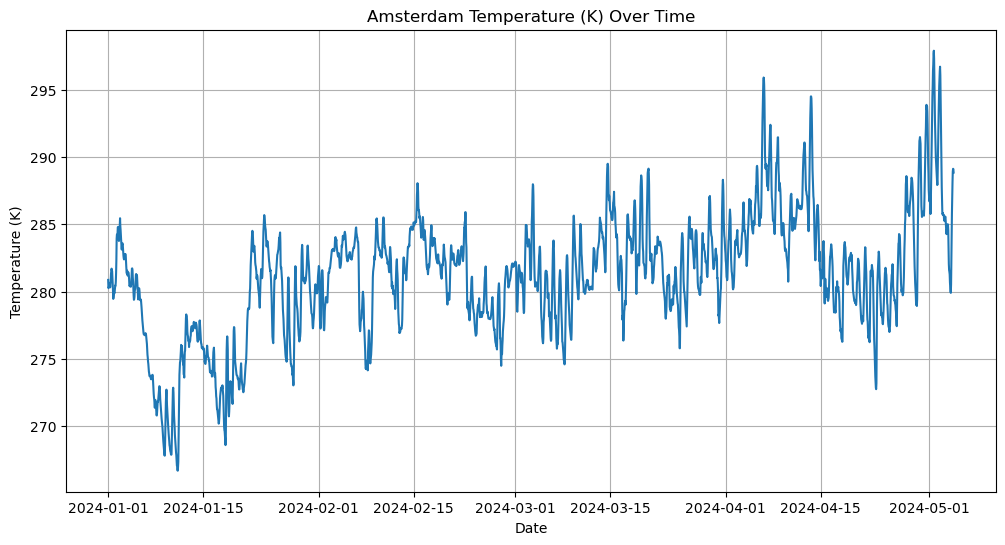

In [46]:
plt.figure(figsize = (12, 6))
plt.plot(ams_ts['time'], ams_ts['t2m'])
plt.title("Amsterdam Temperature (K) Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.grid(True)

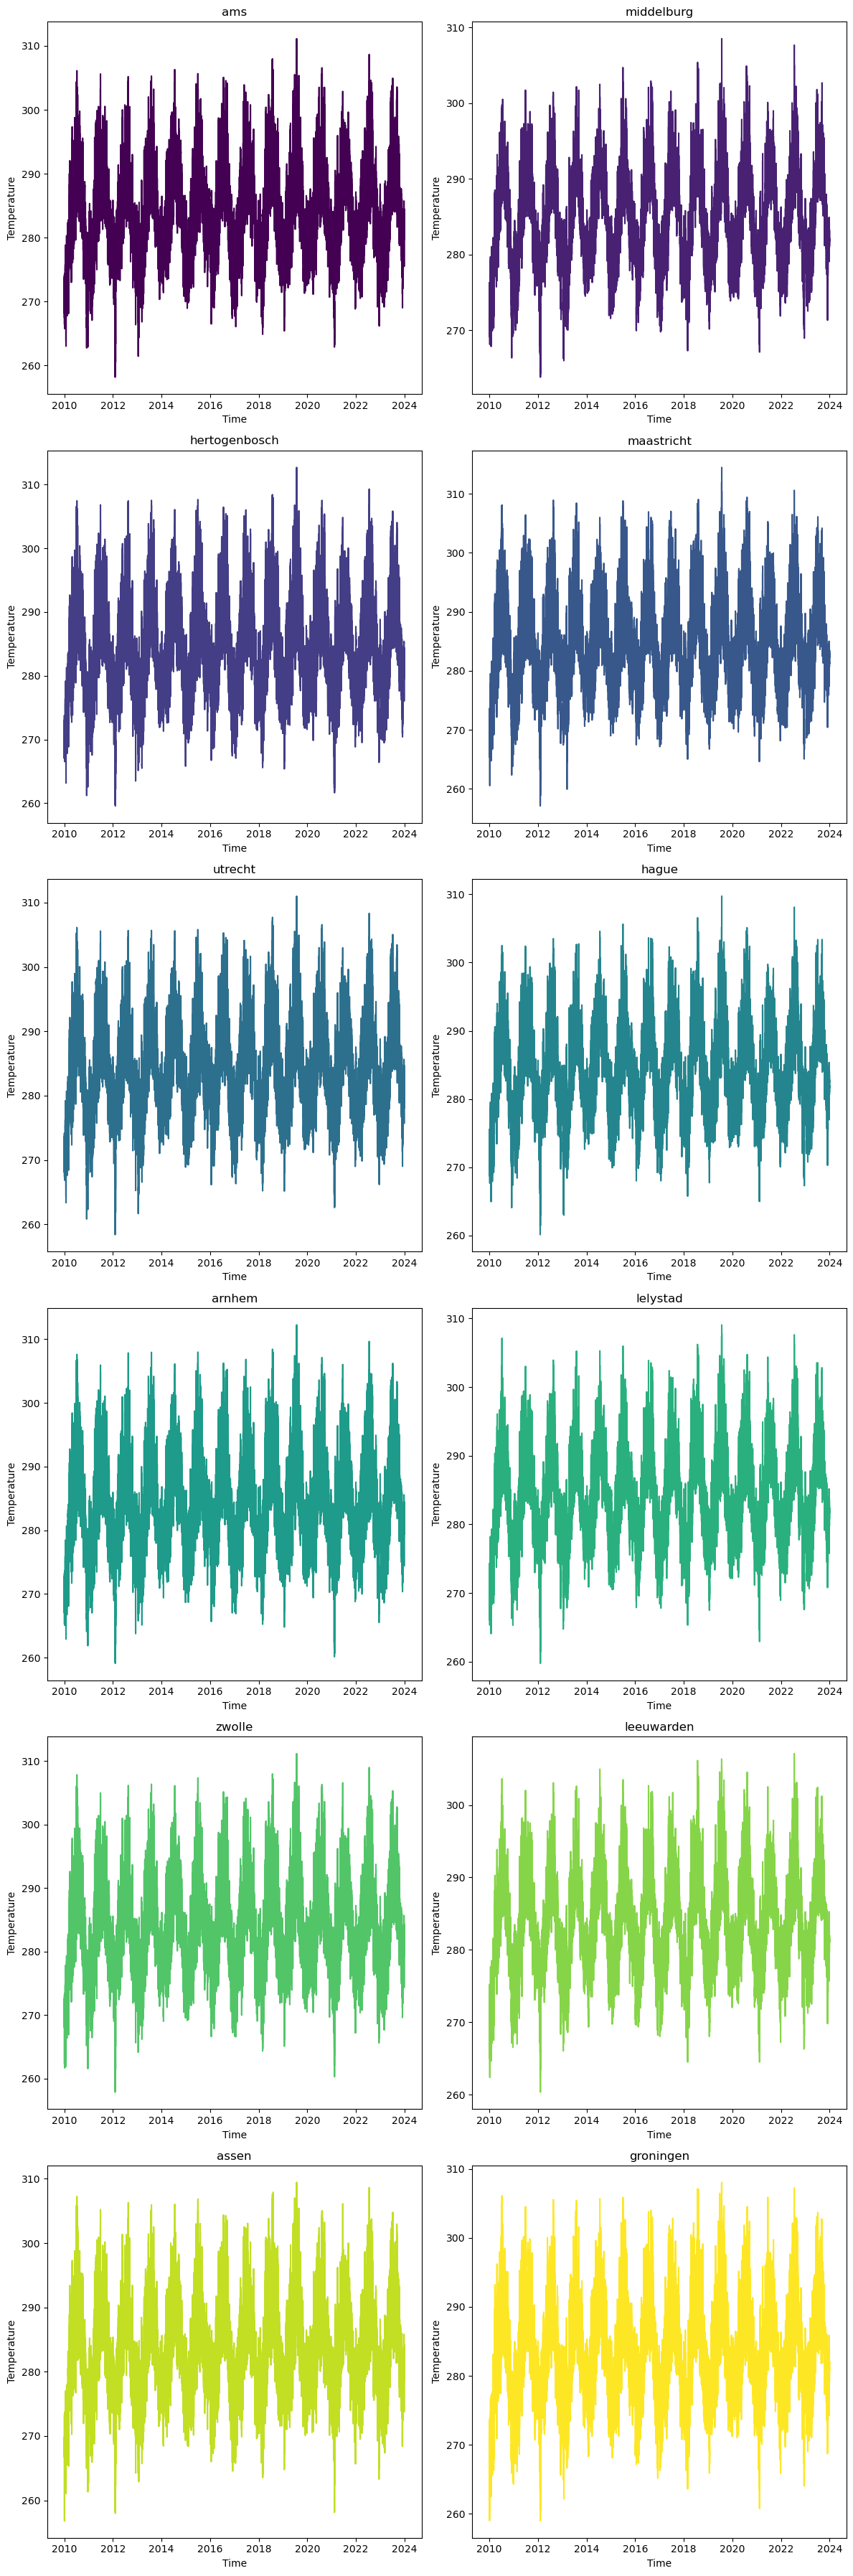

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Example: dataframes_tr = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_tr)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_tr, colors)):
    row = i // num_cols
    col = i % num_cols

    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city['time'].dtype, np.datetime64):
        city['time'] = pd.to_datetime(city['time'])

    axs[row, col].plot(city['time'], city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

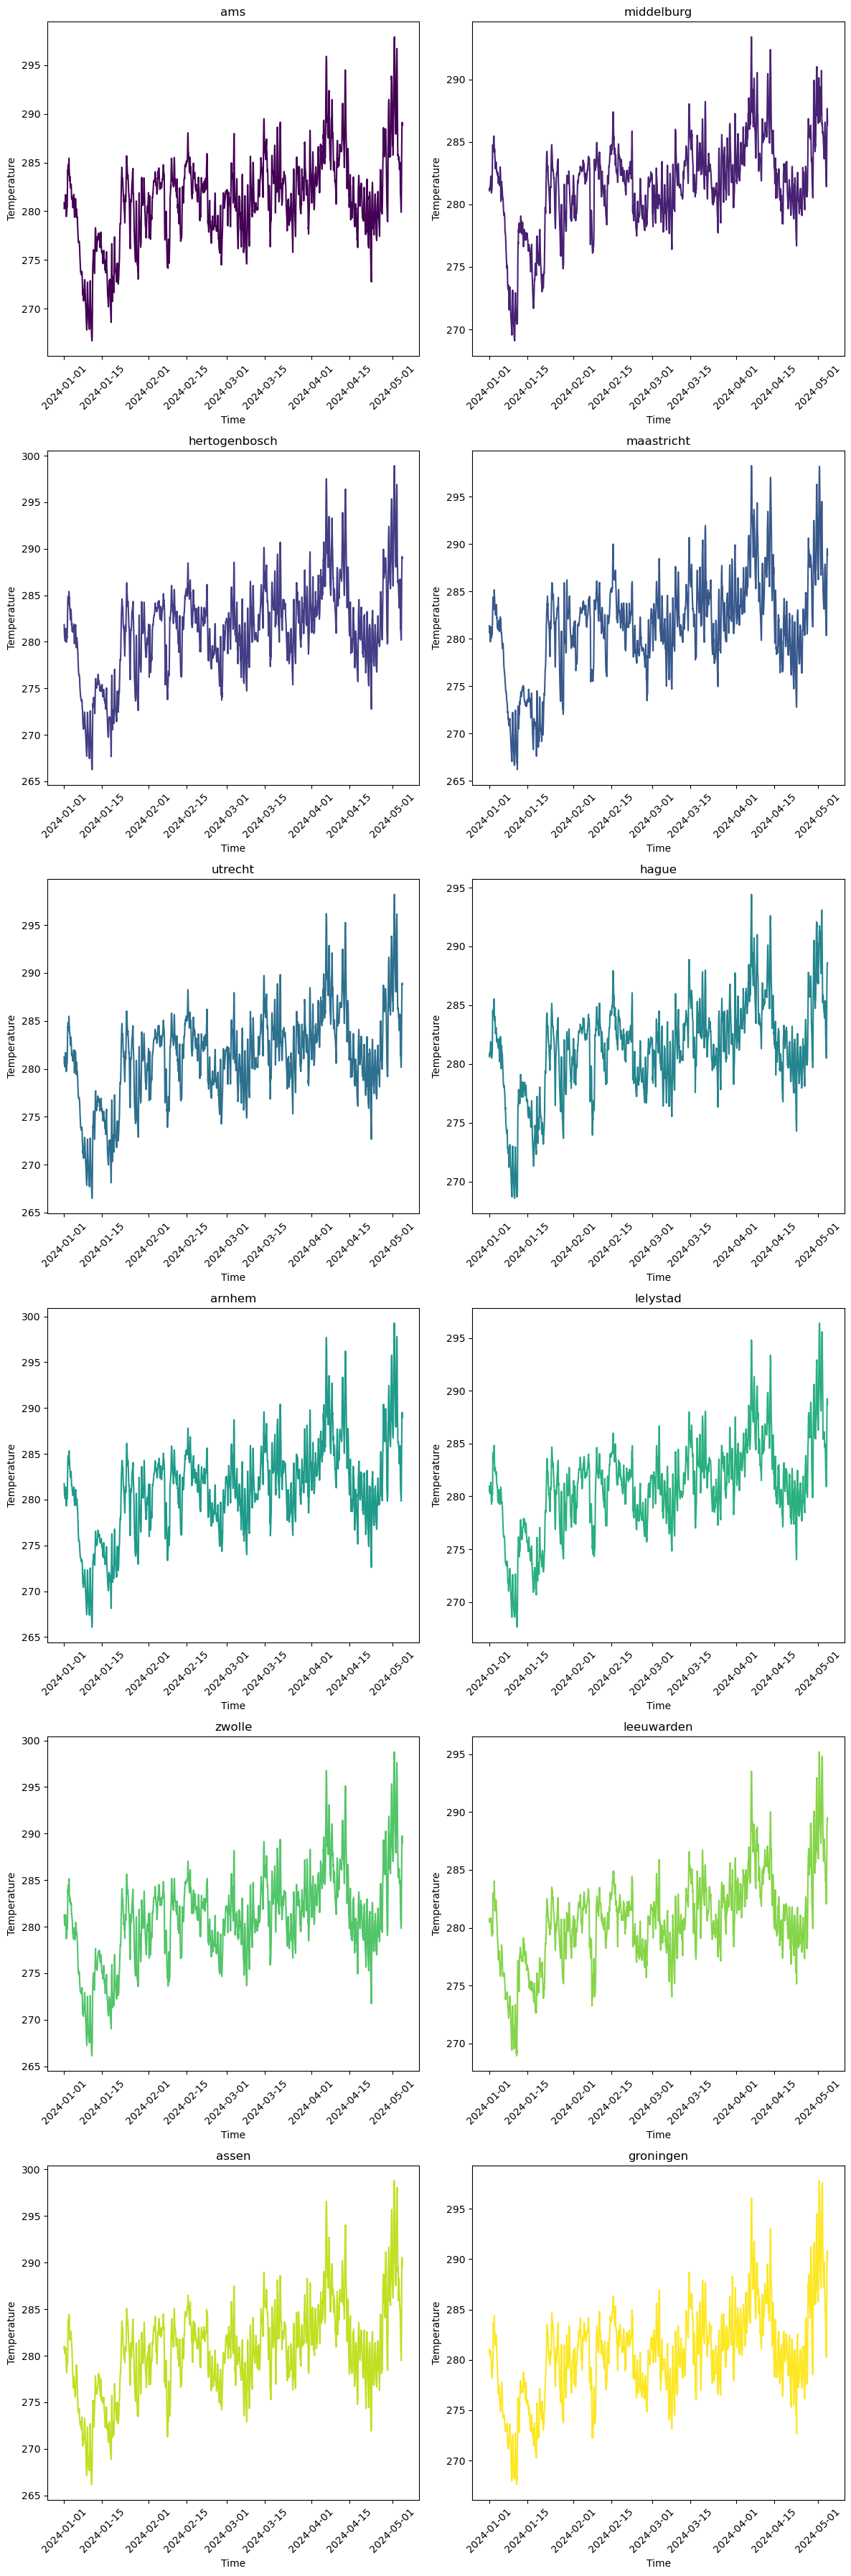

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Example: dataframes_ts = [city1_df, city2_df, city3_df, ...]
# Each DataFrame should have a 'time' column and 't2m' column (temperature).

num_cities = len(dataframes_ts)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Generate a list of colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_cities))

for i, (city, color) in enumerate(zip(dataframes_ts, colors)):
    row = i // num_cols
    col = i % num_cols
    
    # Assuming 'time' is a column and 't2m' is the temperature column
    # Convert 'time' column to datetime if it's not already
    if not np.issubdtype(city['time'].dtype, np.datetime64):
        city['time'] = pd.to_datetime(city['time'])
    
    axs[row, col].plot(city['time'], city['t2m'], color=color)
    axs[row, col].set_title(df_names[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Temperature')
    # Tilt the x-axis labels
    for tick in axs[row, col].get_xticklabels():
        tick.set_rotation(45)

# If the number of cities is not a perfect multiple of the number of columns,
# hide any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [11]:
X_test_df = {}
Y_test_df = {}

for i, city in enumerate(dataframes_ts):
    df = city.set_index('time').copy()
    X_test = df[['u10', 'v10', 'tcc', 'ptype', 'e', 'sf', 'tp']]
    # , 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
    Y_test = df['t2m']

    scaler = MinMaxScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    Y_test = Y_test.values.reshape(-1, 1)
    Y_test_scaled = scaler.fit_transform(Y_test)

    timestep_test = 24 # pick a timestep, can be anything, used for length of sequence in LSTM

    # below is a general formula to reshape the tensors without errors
    test_trim = X_test_scaled.shape[0] - (X_test_scaled.shape[0] // (timestep_test * X_test_scaled.shape[1])) * (timestep_test * X_test_scaled.shape[1])

    # now can just apply the trim, will work with any value
    X_test_scaled, Y_test_scaled = X_test_scaled[:-test_trim], Y_test_scaled[:-test_trim]

    X_test_tensor = tf.convert_to_tensor(X_test_scaled.reshape(-1, timestep_test, X_test_scaled.shape[1]))

    X_test_df[df_names[i]] = X_test_tensor
    Y_test_df[df_names[i]] = Y_test_scaled

# 2 different approaches

- transfer learning

- separate models for each city

In [59]:
i = 'ams'

tensorXtrain = X_train_df[i]
tensorYtrain = Y_train_df[i]
tensorXvalid = X_valid_df[i]
tensorYvalid = Y_valid_df[i]

# Define model
model = Sequential()
model.add(LSTM(512, input_shape = (timestep, tensorXtrain.shape[2]), return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = True))  # have to set to false if last layer
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences = False))  # have to set to false if last layer
model.add(Dropout(0.1))


model.add(Dense(1)) # dense is your output

# really we are free to try antyhing here, it just takes countless hours to even get something that works better in city A and B etc
optimizer = Adam(learning_rate = 0.001) # anything works, adam is fine, sgd really good
model.compile(optimizer = optimizer, loss = 'mae') # huber works well

# need early stopping to avoid the overfitting
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True)

model.fit(tensorXtrain, tensorYtrain, epochs = 300, batch_size=64, validation_data = (tensorXvalid, tensorYvalid), callbacks = early_stopping)

# predictions = model.predict(tensorXvalid)

# predictions_dict[i] = predictions

# save the model, so we can load them and predict on them quickly for the presentation of the final results
save_dir = os.path.join("/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models", i)
model.save(save_dir)

Epoch 1/300


2024-05-23 21:17:24.864917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:17:28.137562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:17:32.482021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:17:35.604437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:17:39.379310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:17:44.155842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:17:48.308384: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1550

2024-05-23 21:25:22.826672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:25:23.656791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:25:27.019858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:25:29.772735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:25:32.730224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:25:35.552439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:25:38.101542: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - 585s 5s/step - loss: 0.1550 - val_loss: 0.1218
Epoch 2/300
64/64 [==============================] - 22s 345ms/step - loss: 0.1042 - val_loss: 0.1267
Epoch 3/300
64/64 [==============================] - 21s 326ms/step - loss: 0.1037 - val_loss: 0.1208
Epoch 4/300
64/64 [==============================] - 20s 313ms/step - loss: 0.1035 - val_loss: 0.1250
Epoch 5/300
64/64 [==============================] - 21s 331ms/step - loss: 0.1032 - val_loss: 0.1266
Epoch 6/300
64/64 [==============================] - 18s 283ms/step - loss: 0.1031 - val_loss: 0.1232
Epoch 7/300
64/64 [==============================] - 16s 253ms/step - loss: 0.1035 - val_loss: 0.1280
Epoch 8/300
64/64 [==============================] - 15s 232ms/step - loss: 0.1035 - val_loss: 0.1240
Epoch 9/300
64/64 [==============================] - 16s 238ms/step - loss: 0.1027 - val_loss: 0.1258
Epoch 10/300
64/64 [==============================] - 15s 237ms/step - loss: 0.1035 - val_loss: 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/ams/assets


In [51]:
predictions_dict = {} # store model predictions
predictions_unseen = {}

for i in df_names:

    tensorXtrain = X_train_df[i]
    tensorYtrain = Y_train_df[i]
    tensorXvalid = X_valid_df[i]
    tensorYvalid = Y_valid_df[i]

    # Define model
    model = Sequential()
    model.add(LSTM(128, input_shape = (timestep, tensorXtrain.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(64, return_sequences = True))  # have to set to false if last layer
    model.add(Dropout(0.2))

    model.add(LSTM(32, return_sequences = False))  # have to set to false if last layer
    model.add(Dropout(0.1))

    model.add(Dense(1)) # dense is your output

    # really we are free to try antyhing here, it just takes countless hours to even get something that works better in city A and B etc
    optimizer = Adam(learning_rate = 0.001) # anything works, adam is fine, sgd really good
    model.compile(optimizer = optimizer, loss = 'mae') # huber works well

    # need early stopping to avoid the overfitting
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

    model.fit(tensorXtrain, tensorYtrain, epochs = 50, batch_size=64, validation_data = (tensorXvalid, tensorYvalid), callbacks = early_stopping)

    # predictions = model.predict(tensorXvalid)

    # predictions_dict[i] = predictions

    # save the model, so we can load them and predict on them quickly for the presentation of the final results
    save_dir = os.path.join("/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models", i)
    model.save(save_dir)

    # here we shift to the test data, things can be done here but it is VERY HARD to optimize <- it just sucks hard
    # tensorXtest = X_test_df[i]
    # test_predict = model.predict(tensorXtest)

    # prediction_copies = np.repeat(test_predict, timestep - 1, axis = -1)
    # true_predict = scaler.inverse_transform(test_predict)

    # predictions_unseen[i] = true_predict

    K.clear_session()
    gc.collect()

Epoch 1/50


2024-05-23 20:34:29.938082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:34:30.263991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:34:34.922991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:34:37.370174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:34:43.059955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:34:48.149551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:34:53.479155: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1285

2024-05-23 20:35:21.695422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:35:22.042768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:35:24.351716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:35:25.990265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 65s 585ms/step - loss: 0.1285 - val_loss: 0.1178
Epoch 2/50
64/64 [==============================] - 3s 52ms/step - loss: 0.0925 - val_loss: 0.1085
Epoch 3/50
64/64 [==============================] - 3s 43ms/step - loss: 0.0831 - val_loss: 0.1074
Epoch 4/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0782 - val_loss: 0.0944
Epoch 5/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0727 - val_loss: 0.0990
Epoch 6/50
64/64 [==============================] - 5s 79ms/step - loss: 0.0720 - val_loss: 0.1156
Epoch 7/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0728 - val_loss: 0.0993
Epoch 8/50
64/64 [==============================] - 2s 29ms/step - loss: 0.0707 - val_loss: 0.1037
Epoch 9/50
64/64 [==============================] - 2s 28ms/step - loss: 0.0693 - val_loss: 0.1030
INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/mod

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/ams/assets


Epoch 1/50


2024-05-23 20:36:02.131052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:02.471044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:06.742456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:09.257881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:15.056212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:20.321413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:25.221767: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1217

2024-05-23 20:36:53.847643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:54.008951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:56.066958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:36:57.918030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 64s 574ms/step - loss: 0.1217 - val_loss: 0.1138
Epoch 2/50
64/64 [==============================] - 4s 63ms/step - loss: 0.0937 - val_loss: 0.1111
Epoch 3/50
64/64 [==============================] - 3s 51ms/step - loss: 0.0827 - val_loss: 0.1120
Epoch 4/50
64/64 [==============================] - 4s 69ms/step - loss: 0.0789 - val_loss: 0.0906
Epoch 5/50
64/64 [==============================] - 3s 42ms/step - loss: 0.0737 - val_loss: 0.0858
Epoch 6/50
64/64 [==============================] - 2s 37ms/step - loss: 0.0731 - val_loss: 0.0917
Epoch 7/50
64/64 [==============================] - 3s 42ms/step - loss: 0.0711 - val_loss: 0.0855
Epoch 8/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0733 - val_loss: 0.0838
Epoch 9/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0711 - val_loss: 0.0830
Epoch 10/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0717 - val_loss: 0.0818
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/middelburg/assets


Epoch 1/50


2024-05-23 20:37:45.967593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:37:46.822056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:37:49.595823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:37:52.330315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:37:58.186197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:38:03.913576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:38:09.408717: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1130

2024-05-23 20:38:41.819675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:38:41.929074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:38:44.359404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:38:46.402314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 70s 626ms/step - loss: 0.1130 - val_loss: 0.1114
Epoch 2/50
64/64 [==============================] - 5s 76ms/step - loss: 0.0907 - val_loss: 0.1042
Epoch 3/50
64/64 [==============================] - 3s 41ms/step - loss: 0.0803 - val_loss: 0.0989
Epoch 4/50
64/64 [==============================] - 2s 28ms/step - loss: 0.0777 - val_loss: 0.1017
Epoch 5/50
64/64 [==============================] - 2s 37ms/step - loss: 0.0755 - val_loss: 0.0941
Epoch 6/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0776 - val_loss: 0.0969
Epoch 7/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0741 - val_loss: 0.0932
Epoch 8/50
64/64 [==============================] - 2s 28ms/step - loss: 0.0739 - val_loss: 0.0943
Epoch 9/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0740 - val_loss: 0.0912
Epoch 10/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0734 - val_loss: 0.0928
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/hertogenbosch/assets


Epoch 1/50


2024-05-23 20:39:50.152008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:39:50.482846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:39:55.636848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:39:58.185163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:40:02.963884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:40:07.890987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:40:12.915803: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1184

2024-05-23 20:40:44.551337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:40:44.656405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:40:47.737512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:40:49.047280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 67s 607ms/step - loss: 0.1184 - val_loss: 0.1171
Epoch 2/50
64/64 [==============================] - 4s 62ms/step - loss: 0.0875 - val_loss: 0.0995
Epoch 3/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0805 - val_loss: 0.1040
Epoch 4/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0761 - val_loss: 0.0980
Epoch 5/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0760 - val_loss: 0.1026
Epoch 6/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0734 - val_loss: 0.1135
Epoch 7/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0741 - val_loss: 0.0980
Epoch 8/50
64/64 [==============================] - 1s 23ms/step - loss: 0.0743 - val_loss: 0.0972
Epoch 9/50
64/64 [==============================] - 2s 29ms/step - loss: 0.0701 - val_loss: 0.1011
Epoch 10/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0706 - val_loss: 0.1170
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/maastricht/assets


Epoch 1/50


2024-05-23 20:41:33.878503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:41:34.776538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:41:38.287997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:41:41.433646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:41:47.257373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:41:52.863743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:41:57.957748: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1259

2024-05-23 20:42:31.395261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:42:31.507529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:42:34.324829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:42:36.363667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 73s 674ms/step - loss: 0.1259 - val_loss: 0.1170
Epoch 2/50
64/64 [==============================] - 5s 80ms/step - loss: 0.0897 - val_loss: 0.1028
Epoch 3/50
64/64 [==============================] - 3s 50ms/step - loss: 0.0820 - val_loss: 0.1101
Epoch 4/50
64/64 [==============================] - 3s 51ms/step - loss: 0.0787 - val_loss: 0.1111
Epoch 5/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0736 - val_loss: 0.1074
Epoch 6/50
64/64 [==============================] - 2s 36ms/step - loss: 0.0730 - val_loss: 0.1242
Epoch 7/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0718 - val_loss: 0.1033
INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/utrecht/assets


INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/utrecht/assets


Epoch 1/50


2024-05-23 20:43:10.777438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:11.780138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:15.357662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:17.087576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:22.484921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:27.272214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:30.817495: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1093

2024-05-23 20:43:57.837878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:57.943674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:43:59.926703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:44:02.402740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 59s 518ms/step - loss: 0.1093 - val_loss: 0.1079
Epoch 2/50
64/64 [==============================] - 5s 72ms/step - loss: 0.0872 - val_loss: 0.1012
Epoch 3/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0781 - val_loss: 0.1099
Epoch 4/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0747 - val_loss: 0.0987
Epoch 5/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0731 - val_loss: 0.0993
Epoch 6/50
64/64 [==============================] - 3s 43ms/step - loss: 0.0706 - val_loss: 0.0864
Epoch 7/50
64/64 [==============================] - 3s 40ms/step - loss: 0.0702 - val_loss: 0.1217
Epoch 8/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0688 - val_loss: 0.1087
Epoch 9/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0675 - val_loss: 0.1126
Epoch 10/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0686 - val_loss: 0.0897
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/hague/assets


Epoch 1/50


2024-05-23 20:44:40.366700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:44:40.694660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:44:44.314891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:44:47.842781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:44:53.339516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:44:58.785444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:45:05.556538: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1235

2024-05-23 20:45:37.935536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:45:38.049049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:45:39.529287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:45:41.551115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 69s 590ms/step - loss: 0.1235 - val_loss: 0.1201
Epoch 2/50
64/64 [==============================] - 4s 62ms/step - loss: 0.0942 - val_loss: 0.1076
Epoch 3/50
64/64 [==============================] - 3s 53ms/step - loss: 0.0865 - val_loss: 0.0972
Epoch 4/50
64/64 [==============================] - 2s 36ms/step - loss: 0.0845 - val_loss: 0.0942
Epoch 5/50
64/64 [==============================] - 2s 28ms/step - loss: 0.0787 - val_loss: 0.0928
Epoch 6/50
64/64 [==============================] - 2s 37ms/step - loss: 0.0779 - val_loss: 0.0903
Epoch 7/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0787 - val_loss: 0.0984
Epoch 8/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0780 - val_loss: 0.0895
Epoch 9/50
64/64 [==============================] - 2s 29ms/step - loss: 0.0754 - val_loss: 0.1007
Epoch 10/50
64/64 [==============================] - 2s 28ms/step - loss: 0.0762 - val_loss: 0.0898
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/arnhem/assets


Epoch 1/50


2024-05-23 20:46:34.723146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:46:35.053546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:46:38.708453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:46:41.963688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:46:47.905035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:46:53.314595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:46:58.772630: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1295

2024-05-23 20:47:29.661952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:47:29.774664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:47:32.128771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:47:33.977852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 68s 610ms/step - loss: 0.1295 - val_loss: 0.1292
Epoch 2/50
64/64 [==============================] - 4s 61ms/step - loss: 0.0887 - val_loss: 0.1077
Epoch 3/50
64/64 [==============================] - 3s 44ms/step - loss: 0.0819 - val_loss: 0.1106
Epoch 4/50
64/64 [==============================] - 3s 50ms/step - loss: 0.0777 - val_loss: 0.1234
Epoch 5/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0803 - val_loss: 0.1042
Epoch 6/50
64/64 [==============================] - 3s 39ms/step - loss: 0.0744 - val_loss: 0.0935
Epoch 7/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0739 - val_loss: 0.1274
Epoch 8/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0716 - val_loss: 0.0960
Epoch 9/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0718 - val_loss: 0.0931
Epoch 10/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0723 - val_loss: 0.1003
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/lelystad/assets


Epoch 1/50


2024-05-23 20:48:18.191830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:48:19.266920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:48:22.029993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:48:25.003240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:48:29.375691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:48:34.103074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:48:39.782058: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1264

2024-05-23 20:49:10.863560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:49:11.248678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:49:13.220642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:49:15.645336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 66s 610ms/step - loss: 0.1264 - val_loss: 0.1339
Epoch 2/50
64/64 [==============================] - 6s 98ms/step - loss: 0.0933 - val_loss: 0.1184
Epoch 3/50
64/64 [==============================] - 4s 62ms/step - loss: 0.0805 - val_loss: 0.0994
Epoch 4/50
64/64 [==============================] - 6s 86ms/step - loss: 0.0776 - val_loss: 0.1072
Epoch 5/50
64/64 [==============================] - 3s 42ms/step - loss: 0.0766 - val_loss: 0.0999
Epoch 6/50
64/64 [==============================] - 3s 52ms/step - loss: 0.0761 - val_loss: 0.1027
Epoch 7/50
64/64 [==============================] - 3s 50ms/step - loss: 0.0735 - val_loss: 0.1241
Epoch 8/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0733 - val_loss: 0.0960
Epoch 9/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0731 - val_loss: 0.0962
Epoch 10/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0740 - val_loss: 0.0931
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/zwolle/assets


Epoch 1/50


2024-05-23 20:50:10.548924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:50:11.617641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:50:14.478713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:50:17.905727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:50:24.018796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:50:29.125575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:50:32.767413: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1266

2024-05-23 20:51:03.442784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:51:03.667580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:51:06.403298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:51:08.782519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 68s 625ms/step - loss: 0.1266 - val_loss: 0.1123
Epoch 2/50
64/64 [==============================] - 5s 70ms/step - loss: 0.0993 - val_loss: 0.0988
Epoch 3/50
64/64 [==============================] - 3s 46ms/step - loss: 0.0859 - val_loss: 0.0856
Epoch 4/50
64/64 [==============================] - 2s 37ms/step - loss: 0.0804 - val_loss: 0.0918
Epoch 5/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0780 - val_loss: 0.0872
Epoch 6/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0801 - val_loss: 0.0919
Epoch 7/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0750 - val_loss: 0.0840
Epoch 8/50
64/64 [==============================] - 3s 46ms/step - loss: 0.0788 - val_loss: 0.0886
Epoch 9/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0748 - val_loss: 0.0850
Epoch 10/50
64/64 [==============================] - 2s 25ms/step - loss: 0.0751 - val_loss: 0.0823
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/leeuwarden/assets


Epoch 1/50


2024-05-23 20:52:02.617058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:52:03.537814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:52:07.813047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:52:11.054048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:52:16.537956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:52:21.595798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:52:27.723637: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1217

2024-05-23 20:53:04.283839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:53:04.399814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:53:07.965952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:53:10.112461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 76s 724ms/step - loss: 0.1217 - val_loss: 0.1096
Epoch 2/50
64/64 [==============================] - 4s 61ms/step - loss: 0.0943 - val_loss: 0.1075
Epoch 3/50
64/64 [==============================] - 2s 38ms/step - loss: 0.0842 - val_loss: 0.0926
Epoch 4/50
64/64 [==============================] - 2s 37ms/step - loss: 0.0812 - val_loss: 0.1150
Epoch 5/50
64/64 [==============================] - 3s 44ms/step - loss: 0.0806 - val_loss: 0.0899
Epoch 6/50
64/64 [==============================] - 3s 41ms/step - loss: 0.0803 - val_loss: 0.0905
Epoch 7/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0762 - val_loss: 0.0932
Epoch 8/50
64/64 [==============================] - 2s 38ms/step - loss: 0.0741 - val_loss: 0.0947
Epoch 9/50
64/64 [==============================] - 2s 37ms/step - loss: 0.0747 - val_loss: 0.0929
Epoch 10/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0740 - val_loss: 0.0867
Epoch 11/50
64/64 

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/assen/assets


Epoch 1/50


2024-05-23 20:53:58.206569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:53:58.571660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:54:02.645220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:54:05.752339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:54:10.209314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:54:14.808941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:54:20.227742: I tensorflow/core/grappler/optimizers/cust

64/64 [==============================] - ETA: 0s - loss: 0.1252

2024-05-23 20:54:57.925140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:54:58.415153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:55:01.471864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 20:55:03.977333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 75s 746ms/step - loss: 0.1252 - val_loss: 0.1092
Epoch 2/50
64/64 [==============================] - 7s 100ms/step - loss: 0.0953 - val_loss: 0.0963
Epoch 3/50
64/64 [==============================] - 4s 56ms/step - loss: 0.0886 - val_loss: 0.0921
Epoch 4/50
64/64 [==============================] - 3s 43ms/step - loss: 0.0843 - val_loss: 0.1097
Epoch 5/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0809 - val_loss: 0.0891
Epoch 6/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0813 - val_loss: 0.1053
Epoch 7/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0787 - val_loss: 0.1060
Epoch 8/50
64/64 [==============================] - 2s 38ms/step - loss: 0.0766 - val_loss: 0.0904
Epoch 9/50
64/64 [==============================] - 2s 27ms/step - loss: 0.0780 - val_loss: 0.0886
Epoch 10/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0766 - val_loss: 0.0919
Epoch 11/50
64/64

INFO:tensorflow:Assets written to: /Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models/groningen/assets


2024-05-23 21:13:27.665708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:13:28.166518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:13:31.011578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:13:33.415207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:13:35.470295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:13:37.508435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:13:39.571630: I tensorflow/core/grappler/optimizers/cust

4/4 [==============================] - 31s 2s/step


2024-05-23 21:13:59.746652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:00.034504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:01.483577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:04.848711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 11s 989ms/step


2024-05-23 21:14:12.182999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:12.487570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:15.682761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:17.351434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 11s 751ms/step


2024-05-23 21:14:25.522863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:25.830137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:29.280020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:32.367173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 12s 845ms/step


2024-05-23 21:14:39.801666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:40.097117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:43.412737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:45.662741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 13s 923ms/step


2024-05-23 21:14:53.800854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:54.101330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:14:57.827484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:00.742592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 13s 1s/step


2024-05-23 21:15:09.133685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:09.438080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:13.346014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:15.526708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 12s 807ms/step


2024-05-23 21:15:22.078247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:22.362555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:23.825237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:24.985692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 7s 901ms/step


2024-05-23 21:15:31.117256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:31.394643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:35.524172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:36.899864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 10s 607ms/step


2024-05-23 21:15:43.280547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:43.555886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:46.507971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:48.528863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 10s 723ms/step


2024-05-23 21:15:54.483214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:54.756133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:56.113680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:15:57.186130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 8s 1s/step


2024-05-23 21:16:04.437622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:16:04.729031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:16:06.274035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 21:16:07.554916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 7s 429ms/step


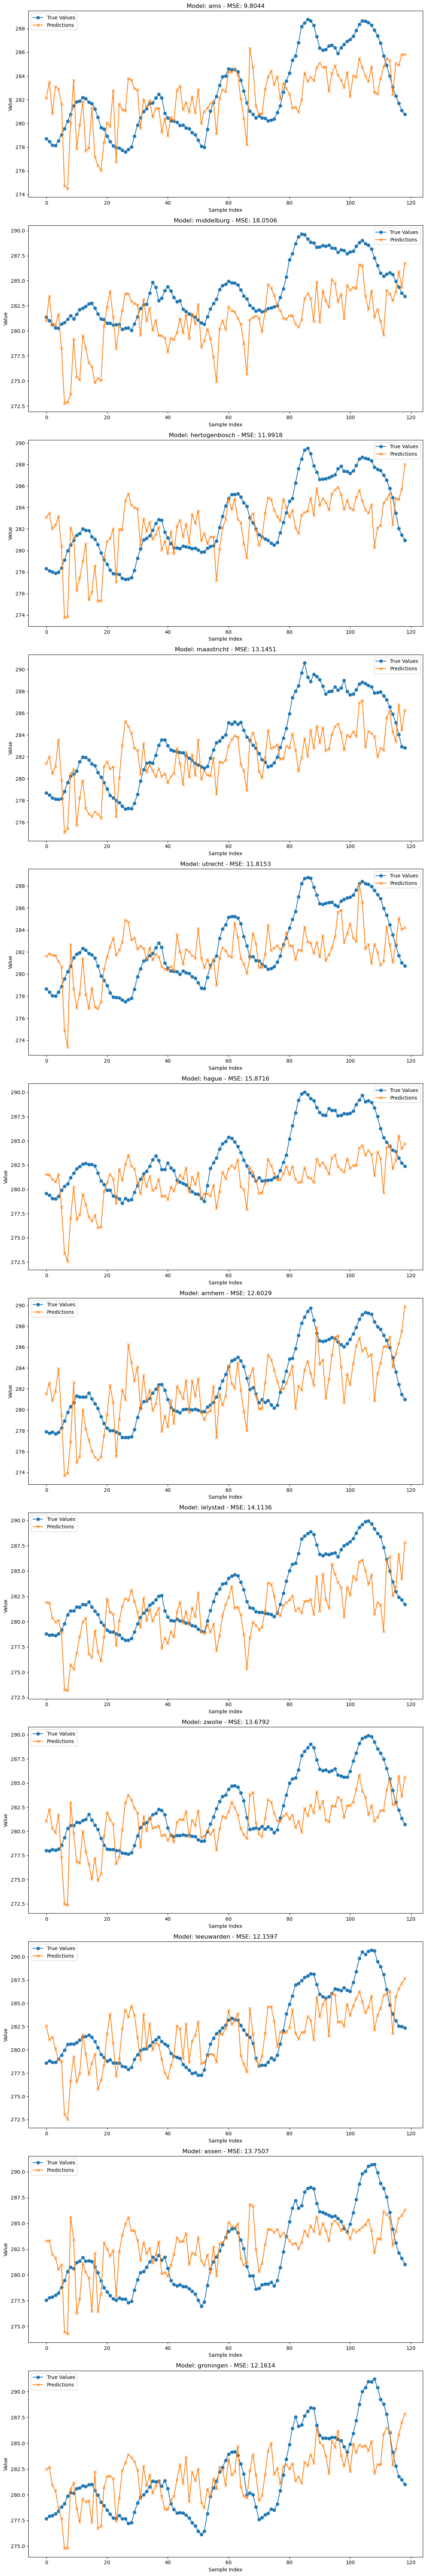

In [58]:
# Assuming X_test_df and Y_test_df are dictionaries of test dataframes
# df_names is the list of keys in these dictionaries
# scaler is a fitted MinMaxScaler instance

predictions_unseen = {}
predictions_check = {}
mse_values = {}

for i in df_names:
    # Load the model
    model = load_model(os.path.join("/Users/lpaggen/Documents/DACS COURSES/Project2-2/Project_2-2/Python/LSTM/my_dir/models", i))

    # Get the test data for the current model
    tensorXtest = X_test_df[i]
    scaledYtest = Y_test_df[i]

    # Make predictions
    test_predict = model.predict(tensorXtest)

    # Reshape scaledYtest for inverse transform
    scaledYtest_reshaped = scaledYtest.reshape(-1, 1)
    true_temp = scaler.inverse_transform(scaledYtest_reshaped)

    # Check the shape of test_predict
    if len(test_predict.shape) == 3:
        # If the shape is (n_samples, timesteps, n_features)
        n_samples, timesteps, n_features = test_predict.shape
        test_predict_reshaped = test_predict.reshape(n_samples * timesteps, n_features)
    elif len(test_predict.shape) == 2:
        # If the shape is (n_samples, n_features)
        n_samples, n_features = test_predict.shape
        timesteps = 1  # Since we have only one timestep
        test_predict_reshaped = test_predict

    # Apply inverse transform to predictions
    true_predict_reshaped = scaler.inverse_transform(test_predict_reshaped)

    # Reshape back to original dimensions if necessary
    if timesteps > 1:
        true_predict = true_predict_reshaped.reshape(n_samples, timesteps, n_features)
    else:
        true_predict = true_predict_reshaped

    # Store the inverse-transformed predictions
    if timesteps > 1:
        tp = true_predict[:, -1, 0]  # Assuming we are interested in the last timestep prediction for each sample
    else:
        tp = true_predict[:, 0]  # Only one timestep, take the first element

    Y_test = true_temp.reshape(-1)  # Assuming Y_test was originally 1-dimensional

    predictions_check[i] = Y_test
    predictions_unseen[i] = tp

    # Calculate MSE
    mse = mean_squared_error(Y_test[-len(tp):], tp)
    mse_values[i] = mse

# Plotting the true values and predictions
fig, axes = plt.subplots(len(df_names), 1, figsize=(12, 6 * len(df_names)))

if len(df_names) == 1:
    axes = [axes]

for idx, i in enumerate(df_names):
    ax = axes[idx]
    ax.plot(predictions_check[i][-len(predictions_unseen[i]):], label='True Values', marker='o')
    ax.plot(predictions_unseen[i], label='Predictions', marker='x')
    ax.set_title(f'Model: {i} - MSE: {mse_values[i]:.4f}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

**LSTM NOTES**

-> using Adam doesn't give great results
-> using rmsprop gives better results